In [1]:
import sys
import os
import numpy as np
import tensorflow as tf


py_file_location = "..."
os.path.abspath(os.path.join(os.path.dirname(py_file_location), os.path.pardir))

from src.close_policy import *
from src.utils import *
from src.metrics import *
from src.DNN_metrics import *
from src.DNN_model import *
from src.loss_function import *
from src.data_generator import *

2022-09-16 11:25:21.456541: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [80]:

print(tf.config.list_physical_devices())
tf.device('GPU:1') 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [81]:
test_size = int(2E5) 

root_dir ='DNN'

# # choose your directory path  
project_sub_path = "dataset"
  
# Parent Directory path
parent_dir = ""


### Test ### 

dataset_test = np.load(os.path.join(parent_dir,project_sub_path,'dataset_test.npz'))


g_PP_ts = dataset_test['g_PP'][:test_size]
g_PS_ts = dataset_test['g_PS'][:test_size]
g_PR_ts = dataset_test['g_PR'][:test_size]
g_SP_ts = dataset_test['g_SP'][:test_size]
g_SS_ts = dataset_test['g_SS'][:test_size]
g_SR_ts = dataset_test['g_SR'][:test_size]
g_RP_ts = dataset_test['g_RP'][:test_size]
g_RS_ts = dataset_test['g_RS'][:test_size]

R_S_ts = dataset_test['R_S']
alpha_ts = dataset_test['alpha']
P_R_ts = dataset_test['P_R']
P_S_ts = dataset_test['P_S']


x_test = np.stack([g_RP_ts, g_PP_ts, g_SR_ts, g_PR_ts, g_SS_ts, g_RS_ts, g_SP_ts, g_PS_ts], axis=1)

y_test = np.stack([R_S_ts, alpha_ts, P_R_ts, P_S_ts], axis=1)



### Performance within the test set 

the figure below represent the intersted results of $\lambda$ hyperparameters  = 0.5 and $\lambda$ = 2.

In [83]:
LD = {'10_0.5':10**0.5,'10_2':10**2}

loss_history =  history_extraction(LD, 'loss')
val_loss_history = history_extraction(LD, 'val_loss')

#rate_history =  history_extraction(LD, 'throughput')
#val_rate_history = history_extraction(LD, 'val_throughput')

#pard_history =  history_extraction(LD, 'Primary_Achievable_Rate_Degradation')
#val_pard_history = history_extraction(LD, 'val_Primary_Achievable_Rate_Degradation')

#Outage_history = history_extraction(LD, 'Primary_ARDP') outage ? !! 
#val_Outage_history = history_extraction(LD, 'val_Primary_ARDP') !! 


#pard_history, pard_history = percentage(pard_history), percentage(val_pard_history)

#QoS_history, val_QoS_history = percentage(QoS_history), percentage(val_QoS_history)

In [6]:
# # choose your directory path  
project_sub_path = "results"
  
# Parent Directory path
parent_dir = ""
  
# Path
try : 

    path = os.path.join(parent_dir, project_sub_path)
    os.mkdir(path)
    print(" '% s' folder created" % project_sub_path)
except FileExistsError : 
    pass

 'results' folder created


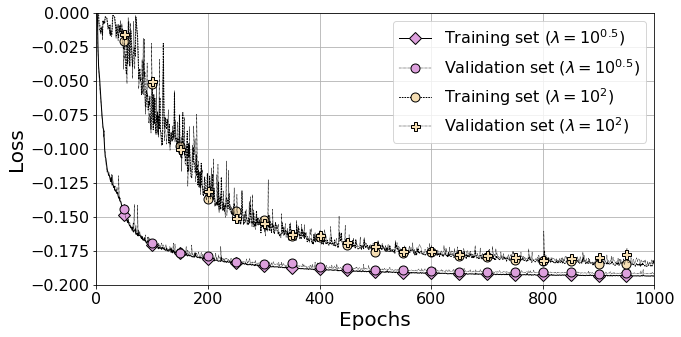

In [84]:
#'Model loss' : 
train_evaluation(loss_history, val_loss_history, 'Loss', [0,1000], [-0.20,0], LD, 'results/loss')

# 'Secondary achievable rate' :

#train_evaluation(rate_history, val_rate_history, r'Rate $(bit/s/Hz)$', [0,10], [-0.20,0], LD, 'Results/') 

# Primary network violation : 

#train_evaluation(Outage_history, val_Outage_history, 'Outage (%)', [0,10], [-0.20,0], LD, 'Results/') 

# Instantaneous primary acheivable rate degradation :

#train_evaluation(pard_history, val_pard_history, 'Mean $\ D_{i}$ (%)', [0,10], [-0.20,0], LD, 'Results/')

###  Average and maximum primary rate degradation and average degradation when in outage as functions of $
\lambda$

### Second figure is for G and Outage 

In [85]:
LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}

rate_gap = secondary_users_stats(x_test[:,:], y_test[:,:], LD, LR)    

P_stats = primary_users_stats(x_test[:,:], y_test[:,:], LD, LR)    



6250/6250 [==============================] - 8s 1ms/step


In [70]:
P_stats = np.squeeze(P_stats)

rate_gap = np.squeeze(rate_gap)

In [73]:
mean_delta, max_delta, delta_out, outage = P_stats[:,0], P_stats[:,1], P_stats[:,2], P_stats[:,3]

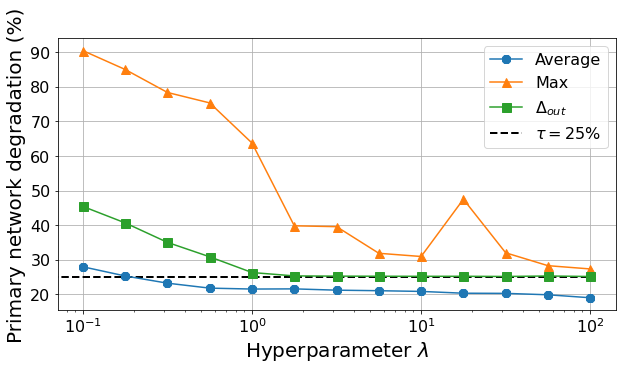

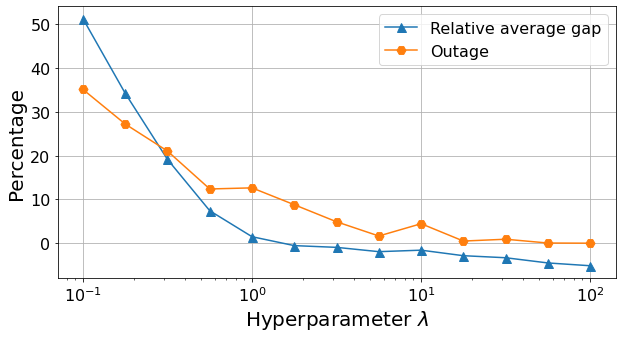

In [77]:
test_evaluation(rate_gap, mean_delta, max_delta, delta_out, outage)



### Histogram of the primary rate degradation over the test set

6250/6250 [==============================] - 8s 1ms/step


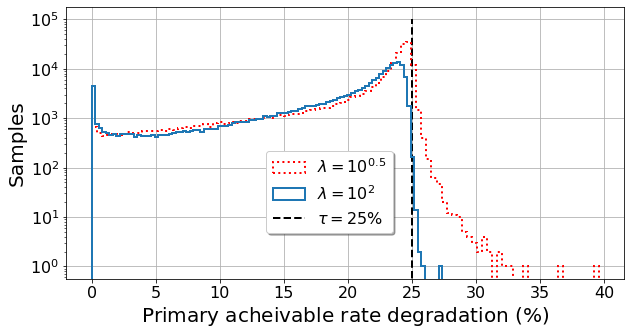

In [92]:
P_P, tau = 10.0, 0.25


model = tf.keras.models.load_model(root_dir+'/lambda = 10_0.5/weights/10_0.5.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'opportunistic_rate':opportunistic_rate_DF(Lambda, tau, P_P), 'outage':outage_DF(Lambda, tau, P_P),'Delta': delta_DF(Lambda, tau, P_P), 'delta_out':delta_out_DF(Lambda, tau, P_P), 'V_Qos':quality_of_service_violation_DF(tau=0.25),"custom_sigmoid":custom_sigmoid})

model_2 = tf.keras.models.load_model(root_dir+'/lambda = 10_2/weights/10_2.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'opportunistic_rate':opportunistic_rate_DF(Lambda, tau, P_P), 'outage':outage_DF(Lambda, tau, P_P),'Delta': delta_DF(Lambda, tau, P_P), 'delta_out':delta_out_DF(Lambda, tau, P_P), 'V_Qos':quality_of_service_violation_DF(tau=0.25),"custom_sigmoid":custom_sigmoid})

##### Evaluation on test set #####
predictions1 = model.predict(x_test)
predictions2 = model_2.predict(x_test)

histogram(x_test[:,0], x_test[:,1], x_test[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2], predictions2[:,0], predictions2[:,1], predictions2[:,2])
      